## Fit Baker et al data with dynamical model with multiplicative adaptation and mode-specific timescales

$$\tau_r \frac{dr}{dt} = -r + x_s(1-a_s)I_s(t) + x_p(1-a_p)I_p(t)$$

$$\tau_a^s \frac{da_s}{dt} = -a_s + I_s(t) \quad \quad \quad \tau_a^p \frac{da_p}{dt} = -a_p + I_p(t)$$

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize, signal, stats
import sys

from disp import set_plot
from record_1_ma_ext import smlt_ma_ind_ta

cc = np.concatenate

FPS = 30.03
DT = 1/FPS

NNRN = 224
ALPHA = 100

FSAVE = 'data/simple/neur/baker_ma_ind_ta.npy'

In [2]:
# load data
DF_S = pd.read_csv('data/simple/neur/baker_resampled_s.csv')
DF_P = pd.read_csv('data/simple/neur/baker_resampled_p.csv')

I_S = np.array(DF_S['S'])
I_P = np.array(DF_P['P'])

R_SS = np.array(DF_S[[f'R_{cnrn}' for cnrn in range(NNRN)]])
R_PS = np.array(DF_P[[f'R_{cnrn}' for cnrn in range(NNRN)]])

T = np.arange(len(I_S))*DT

In [3]:
nrns_fit = range(NNRN)
# nrns_fit = [13, 14, 34, 35, 37, 38, 40] + [57, 60, 61, 62, 63, 64, 65, 66, 67, 74, 85, 86, 87, 98, 110, 118, 146, 147, 162, 174, 198, 209]

In [4]:
# initial params
params_init_dflt = {'TAU_R': 2, 'TAU_A_S': 5, 'TAU_A_P': 5, 'X_S': 1, 'X_P': 1}
params_init = {
    48: {'TAU_R': 2, 'TAU_A_S': 5, 'TAU_A_P': 5, 'X_S': 10, 'X_P': 1},
    49: {'TAU_R': 2, 'TAU_A_S': 5, 'TAU_A_P': 5, 'X_S': 10, 'X_P': 1},
    52: {'TAU_R': 7, 'TAU_A_S': 100, 'TAU_A_P': 100, 'X_S': -3, 'X_P': -3},
    63: {'TAU_R': 1, 'TAU_A_S': 1, 'TAU_A_P': 1, 'X_S': 7, 'X_P': 0},
    64: {'TAU_R': 1, 'TAU_A_S': 1, 'TAU_A_P': 1, 'X_S': 7, 'X_P': 0},
    65: {'TAU_R': 1, 'TAU_A_S': 1, 'TAU_A_P': 1, 'X_S': 3, 'X_P': -2},
    66: {'TAU_R': 1, 'TAU_A_S': 1, 'TAU_A_P': 1, 'X_S': 7, 'X_P': 0},
    76: {'TAU_R': 2, 'TAU_A_S': 5, 'TAU_A_P': 1, 'X_S': 5, 'X_P': 5},
    77: {'TAU_R': .7, 'TAU_A_S': 2, 'TAU_A_P': 2, 'X_S': 3, 'X_P': 10},
    78: {'TAU_R': .7, 'TAU_A_S': 2, 'TAU_A_P': 2, 'X_S': 0, 'X_P': 10},
    79: {'TAU_R': 1, 'TAU_A_S': 3, 'TAU_A_P': 2, 'X_S': 0, 'X_P': 10},
    80: {'TAU_R': 1, 'TAU_A_S': 3, 'TAU_A_P': 2, 'X_S': 0, 'X_P': 10},
    81: {'TAU_R': 1, 'TAU_A_S': 3.5, 'TAU_A_P': 2, 'X_S': 0, 'X_P': 10},
    82: {'TAU_R': .7, 'TAU_A_S': 2, 'TAU_A_P': 2, 'X_S': 0, 'X_P': 10},
    101: {'TAU_R': 7, 'TAU_A_S': 2, 'TAU_A_P': 2, 'X_S': -3, 'X_P': 10},
    104: {'TAU_R': .7, 'TAU_A_S': 2, 'TAU_A_P': 2, 'X_S': 3, 'X_P': 10},
    105: {'TAU_R': .7, 'TAU_A_S': 2, 'TAU_A_P': 2, 'X_S': 2, 'X_P': 10},
    106: {'TAU_R': .7, 'TAU_A_S': 2, 'TAU_A_P': 2, 'X_S': 0, 'X_P': 10},
    107: {'TAU_R': .7, 'TAU_A_S': 2, 'TAU_A_P': 2, 'X_S': 0, 'X_P': 10},
    108: {'TAU_R': .7, 'TAU_A_S': 2, 'TAU_A_P': 2, 'X_S': 0, 'X_P': 10},
    109: {'TAU_R': .7, 'TAU_A_S': 2, 'TAU_A_P': 2, 'X_S': 0, 'X_P': 10},
    110: {'TAU_R': 10, 'TAU_A_S': .1, 'TAU_A_P': .1, 'X_S': 10, 'X_P': -5},
    112: {'TAU_R': .7, 'TAU_A_S': 2, 'TAU_A_P': 2, 'X_S': 10, 'X_P': -3},
    118: {'TAU_R': .7, 'TAU_A_S': 2, 'TAU_A_P': 2, 'X_S': 0, 'X_P': 10},
    141: {'TAU_R': .7, 'TAU_A_S': 2, 'TAU_A_P': 2, 'X_S': 13, 'X_P': 2},
    142: {'TAU_R': .5, 'TAU_A_S': 1, 'TAU_A_P': 1, 'X_S': 15, 'X_P': 0},
    143: {'TAU_R': .5, 'TAU_A_S': 1, 'TAU_A_P': 1, 'X_S': 15, 'X_P': 0},
    144: {'TAU_R': .5, 'TAU_A_S': 1, 'TAU_A_P': 1, 'X_S': 15, 'X_P': 0},
    145: {'TAU_R': .5, 'TAU_A_S': 1, 'TAU_A_P': 1, 'X_S': 15, 'X_P': 0},
    146: {'TAU_R': 5, 'TAU_A_S': .1, 'TAU_A_P': 1, 'X_S': 2, 'X_P': 2},
    147: {'TAU_R': 5, 'TAU_A_S': .1, 'TAU_A_P': 1, 'X_S': 2, 'X_P': 2},
    148: {'TAU_R': .5, 'TAU_A_S': 1, 'TAU_A_P': 1, 'X_S': 10, 'X_P': 10},
    160: {'TAU_R': .5, 'TAU_A_S': 1, 'TAU_A_P': 1, 'X_S': 10, 'X_P': 10},
    162: {'TAU_R': .5, 'TAU_A_S': .1, 'TAU_A_P': .1, 'X_S': 10, 'X_P': 10},
    164: {'TAU_R': .7, 'TAU_A_S': 2, 'TAU_A_P': 2, 'X_S': 10, 'X_P': 3},
    165: {'TAU_R': .7, 'TAU_A_S': 2, 'TAU_A_P': 1, 'X_S': 5, 'X_P': 5},
    168: {'TAU_R': 1, 'TAU_A_S': 3, 'TAU_A_P': 1, 'X_S': 0, 'X_P': 8},
    169: {'TAU_R': 1, 'TAU_A_S': 5, 'TAU_A_P': 1, 'X_S': 0, 'X_P': 5},
    170: {'TAU_R': 1, 'TAU_A_S': 5, 'TAU_A_P': 1, 'X_S': 0, 'X_P': 5},
    171: {'TAU_R': 1, 'TAU_A_S': 5, 'TAU_A_P': 1, 'X_S': 0, 'X_P': 5},
    173: {'TAU_R': 1, 'TAU_A_S': 5, 'TAU_A_P': 1, 'X_S': 0, 'X_P': 5},
    174: {'TAU_R': .5, 'TAU_A_S': 1, 'TAU_A_P': 1, 'X_S': 15, 'X_P': 10},
    176: {'TAU_R': .7, 'TAU_A_S': 2, 'TAU_A_P': 1, 'X_S': 10, 'X_P': 0},
    177: {'TAU_R': .5, 'TAU_A_S': 1, 'TAU_A_P': 1, 'X_S': 15, 'X_P': 0},
    178: {'TAU_R': .5, 'TAU_A_S': 1, 'TAU_A_P': 1, 'X_S': 15, 'X_P': 0},
    179: {'TAU_R': .5, 'TAU_A_S': 1, 'TAU_A_P': 1, 'X_S': 15, 'X_P': 0},
    180: {'TAU_R': .5, 'TAU_A_S': 1, 'TAU_A_P': 1, 'X_S': 15, 'X_P': 0},
    182: {'TAU_R': .7, 'TAU_A_S': 1.5, 'TAU_A_P': 1.5, 'X_S': 5, 'X_P': 5},
    183: {'TAU_R': .7, 'TAU_A_S': 1.5, 'TAU_A_P': 1, 'X_S': 10, 'X_P': 0},
    184: {'TAU_R': .7, 'TAU_A_S': 2, 'TAU_A_P': 1, 'X_S': 10, 'X_P': 0},
    185: {'TAU_R': .7, 'TAU_A_S': 1.5, 'TAU_A_P': 1, 'X_S': 10, 'X_P': 0},
    191: {'TAU_R': 5, 'TAU_A_S': 1, 'TAU_A_P': 1, 'X_S': 15, 'X_P': 3},
    198: {'TAU_R': 5, 'TAU_A_S': 1, 'TAU_A_P': 1, 'X_S': 15, 'X_P': 3},
    200: {'TAU_R': .7, 'TAU_A_S': 2, 'TAU_A_P': 1, 'X_S': 5, 'X_P': 5},
    201: {'TAU_R': .5, 'TAU_A_S': 1, 'TAU_A_P': 1, 'X_S': 15, 'X_P': 0},
    202: {'TAU_R': .7, 'TAU_A_S': 1.5, 'TAU_A_P': 1, 'X_S': 10, 'X_P': 10},
    204: {'TAU_R': .7, 'TAU_A_S': 3, 'TAU_A_P': 1, 'X_S': 0, 'X_P': 10},
    205: {'TAU_R': .7, 'TAU_A_S': 2, 'TAU_A_P': 1, 'X_S': 0, 'X_P': 10},
    206: {'TAU_R': .7, 'TAU_A_S': 2, 'TAU_A_P': 1, 'X_S': 0, 'X_P': 10},
    207: {'TAU_R': .7, 'TAU_A_S': 2, 'TAU_A_P': 1, 'X_S': 0, 'X_P': 10},
    208: {'TAU_R': .7, 'TAU_A_S': 2, 'TAU_A_P': 1, 'X_S': 0, 'X_P': 10},
    209: {'TAU_R': 5, 'TAU_A_S': 1, 'TAU_A_P': 1, 'X_S': 3, 'X_P': 15},
    210: {'TAU_R': .5, 'TAU_A_S': 1, 'TAU_A_P': 1, 'X_S': 15, 'X_P': 3},
}

for inrn in range(NNRN):
    if inrn not in params_init:
        params_init[inrn] = params_init_dflt

# set of neurons to ignore sine-offset response in fitting
ignore_off_s = [15, 16, 57, 60, 61, 62, 63, 64, 65, 66, 67, 74, 98, 101, 110, 146, 147, 162]
ignore_off_p = [15, 16, 62, 65, 67, 74, 98, 101, 146, 147]

In [5]:
# objective function for MA fit
def obj_ma_ind_ta(param, r_s, r_p):
    tau_r, tau_a_s, tau_a_p, x_s, x_p = param
    
    params_temp = {
        'TAU_R': np.array([tau_r]), 'TAU_A_S': np.array([tau_a_s]), 'TAU_A_P': np.array([tau_a_p]),
        'X_S': np.array([x_s]), 'X_P': np.array([x_p])
    }
    
    r_smln_s = smlt_ma_ind_ta(I_S, 0*I_P, params_temp, DT)[:, 0]
    r_smln_p = smlt_ma_ind_ta(0*I_S, I_P, params_temp, DT)[:, 0]
    
    # compute error
    mse = np.nanmean(cc([r_s-r_smln_s, r_p-r_smln_p])**2)
    return mse

bounds = [(.001, None), (.001, None), (.001, None), (-15, 15), (-15, 15)]

In [6]:
# loop over expt_ids
tau_rs = np.nan*np.zeros(NNRN)
tau_a_ss = np.nan*np.zeros(NNRN)
tau_a_ps = np.nan*np.zeros(NNRN)
x_ss = np.nan*np.zeros(NNRN)
x_ps = np.nan*np.zeros(NNRN)

for cnrn, inrn in enumerate(nrns_fit):
    sys.stdout.write('.')
    
    r_s = R_SS[:, inrn].copy()
    r_p = R_PS[:, inrn].copy()
        
    if inrn in ignore_off_s:
        r_s[T >= 10] = np.nan
    if inrn in ignore_off_p:
        r_p[T >= 10] = np.nan
        
    param = params_init[inrn]
    x_0 = [param['TAU_R'], param['TAU_A_S'], param['TAU_A_P'], param['X_S'], param['X_P']]
    
    # fit model
    np.random.seed(0)
    fit_rslt = optimize.minimize(obj_ma_ind_ta, x_0, args=(r_s, r_p), bounds=bounds)

    # unpack params
    tau_r, tau_a_s, tau_a_p, x_s, x_p = fit_rslt.x
    
    tau_rs[inrn] = tau_r
    tau_a_ss[inrn] = tau_a_s
    tau_a_ps[inrn] = tau_a_p
    x_ss[inrn] = x_s
    x_ps[inrn] = x_p

................................................................................................................................................................................................................................

In [7]:
params_0 = {
    'EXPT_ID': range(NNRN),
    'TAU_R': tau_rs, 'TAU_A_S': tau_a_ss, 'TAU_A_P': tau_a_ps, 'X_S': x_ss, 'X_P': x_ps
}

# Examine fits

In [8]:
r_smln_s_0s = smlt_ma_ind_ta(I_S, 0*I_P, params_0, DT)
r_smln_p_0s = smlt_ma_ind_ta(0*I_S, I_P, params_0, DT)

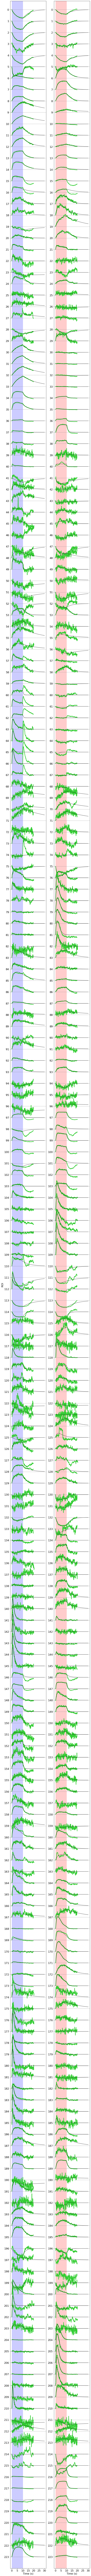

In [9]:
t = np.arange(len(R_SS))*DT

nplot = len(nrns_fit)
fig, axs = plt.subplots(1, 2, figsize=(8, nplot), tight_layout=True)
y_ticks = []

for cnrn, inrn in enumerate(nrns_fit):
    y_tick = -4*cnrn
    
    ## sine response
    axs[0].axhline(y_tick, lw=1, ls='--', c='gray')
    axs[0].plot(t, R_SS[:, inrn] + y_tick, c='limegreen', lw=3)  # true
    axs[0].plot(t, r_smln_s_0s[:, inrn] + y_tick, c='k', lw=1)  # simulated 
    
    ## pulse response
    axs[1].axhline(y_tick, lw=1, ls='--', c='gray')
    axs[1].plot(t, R_PS[:, inrn] + y_tick, c='limegreen', lw=3)
    axs[1].plot(t, r_smln_p_0s[:, inrn] + y_tick, c='k', lw=1)  # simulated
    
    y_ticks.append(y_tick)
    
axs[0].axvspan(0, 10, color='b', alpha=.2)
axs[1].axvspan(0, 10, color='r', alpha=.2)

axs[0].set_ylabel('ROI')

for ax in axs:
    set_plot(ax, y_lim=(-4*nplot, 3), y_ticks=y_ticks, y_tick_labels=nrns_fit, x_label='Time (s)', font_size=16)

In [10]:
np.save(FSAVE, np.array([params_0]))

# Parameter distributions

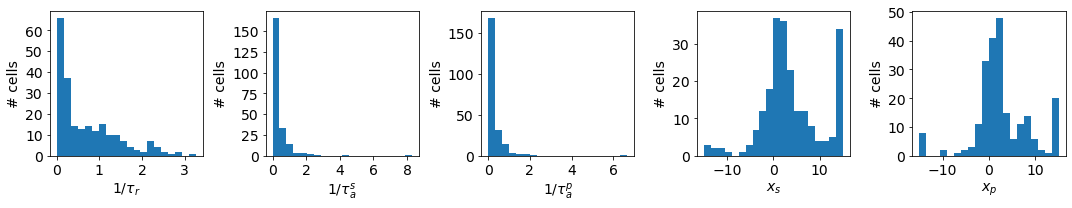

In [11]:
fig, axs = plt.subplots(1, 5, figsize=(15, 3), tight_layout=True)
axs[0].hist(1/tau_rs, bins=20)
axs[0].set_xlabel(r'$1/\tau_r$')

axs[1].hist(1/tau_a_ss, bins=20)
axs[1].set_xlabel(r'$1/\tau_a^s$')

axs[2].hist(1/tau_a_ps, bins=20)
axs[2].set_xlabel(r'$1/\tau_a^p$')

axs[3].hist(x_ss, bins=20)
axs[3].set_xlabel(r'$x_s$')

axs[4].hist(x_ps, bins=20)
axs[4].set_xlabel(r'$x_p$')

for ax in axs:
    set_plot(ax, y_label='# cells', font_size=14)